In [1]:
# Import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import pandas as pd
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

from sqlalchemy import create_engine
import getpass

from tqdm import tqdm

In [2]:
# Create SQL Engine for data importation
DB_NAME = "NFLDB_1"
USERNAME = "root"
PASSWORD = getpass.getpass("Enter your MySQL password: ")
HOST = "localhost"

engine = create_engine(f"mysql+pymysql://{USERNAME}:{PASSWORD}@{HOST}/{DB_NAME}")

In [5]:
# Hyper-parameters
batch_size = 10
learing_rate = .01
num_gaussians = 15
num_epochs = 50
num_stats = 50

In [6]:
# Model architecture
class FantasyFootballTransformer(nn.Module):
    def __init__(self, num_stats=num_stats, d_model=128, num_heads=4, num_layers=3, num_gaussians=3):
        super().__init__()
        
        # Projection layer to map (num_seasons, 6) -> (num_seasons, d_model)
        self.stat_embedding = nn.Linear(num_stats, d_model)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers for Gaussian mixture parameters
        self.fc_mean = nn.Linear(d_model, num_gaussians)  # Means of Gaussians
        self.fc_var = nn.Linear(d_model, num_gaussians)   # Variances (softplus activation)
        self.fc_weight = nn.Linear(d_model, num_gaussians)  # Mixture weights (softmax)

    def forward(self, x, mask=None):
        """
        x: (batch_size, num_seasons, num_stats)
        mask: (batch_size, num_seasons) - 1 for valid tokens, 0 for padding tokens
        """

        x = self.stat_embedding(x)  # Project to d_model dimension
        
        # Transformer Encoder requires a padding mask with shape (batch_size, seq_len)
        if mask is not None:
            # Ensure mask is boolean (True for padding positions, False for valid tokens)
            mask = mask == 0  # Convert to a boolean mask: 1 for padding, 0 for valid tokens
        
        # Process with Transformer, passing the mask
        x = self.transformer(x, src_key_padding_mask=mask)
        
        x = x.mean(dim=1)  # Aggregate across seasons using mean pooling

        means = self.fc_mean(x)  # Shape: (batch_size, num_gaussians)
        variances = F.softplus(self.fc_var(x))  # Ensure positive variances
        weights = F.softmax(self.fc_weight(x), dim=-1)  # Mixture probabilities sum to 1

        return means, variances, weights

In [7]:
# Custom loss function
def gaussian_mixture_nll(y_true, means, variances, weights, mask=None):
    """
    Computes the Negative Log-Likelihood (NLL) loss for a Gaussian Mixture Model.

    Args:
        y_true (tensor): Shape (batch_size,) - actual fantasy points.
        means (tensor): Shape (batch_size, num_gaussians) - predicted Gaussian means.
        variances (tensor): Shape (batch_size, num_gaussians) - predicted Gaussian variances.
        weights (tensor): Shape (batch_size, num_gaussians) - mixture component weights.
        mask (tensor, optional): Shape (batch_size, num_seasons) Mask indicating valid entries (1 for valid, 0 for padded).
    
    Returns:
        loss (tensor): Scalar loss value.
    """

    # Expand y_true to match Gaussian components
    y_true = y_true.unsqueeze(1)  # Shape: (batch_size, 1)

    # Compute Gaussian probability density function
    epsilon = 1e-6  # Small value to avoid division by zero
    std_dev = torch.sqrt(variances)  # Ensure positive standard deviation
    gaussians = (1 / (std_dev * torch.sqrt(torch.tensor(2 * torch.pi)))) * \
                torch.exp(-0.5 * ((y_true - means) / std_dev) ** 2)

    # Weighted sum over the Gaussians
    weighted_gaussians = weights * gaussians  # Shape: (batch_size, num_gaussians)
    likelihood = weighted_gaussians.sum(dim=1)  # Sum over Gaussians per sample

    # Apply mask if provided (make sure masked values are excluded from loss calculation)
    if mask is not None:
        mask = mask.unsqueeze(1)  # Shape: (batch_size, 1)
        mask = mask.expand(-1, means.size(1))  # Shape: (batch_size, num_gaussians)
        mask = mask.sum(dim=1)  # Now mask has shape (batch_size,)
        loss = -torch.log(likelihood + epsilon) * mask  # Now mask is (batch_size,)
    else:
        # If no mask is provided, just compute the loss normally
        loss = -torch.log(likelihood + epsilon).sum()  # Avoid log(0)
    return loss


In [34]:
# Initialize model
model = FantasyFootballTransformer(num_gaussians=num_gaussians)
#model.load_state_dict(torch.load('fantasy_football_transformer.pth'))
optimizer = optim.Adam(model.parameters(), lr=learing_rate)

In [9]:
# Training data processing and batching functions
def build_train_dataset(df: pd.DataFrame):
    df = df.sort_values(by=['season'])
    if df.iloc[-1]['season'] == 2024:
        df = df.iloc[:-1]  # Exclude 2024 since we can't predict it

    Y_tensors = []
    X_tensors = defaultdict(list)  # Dictionary to group by sequence length

    df_stats = df.drop(columns=['season', 'player_id'])
    years = df['season'].values
    stats_data = df_stats.values
    
    # Iterate over each player's seasons, ensuring that we're using multiple seasons for training
    for i in range(1, len(years)):  # Start from season 1 to n
        # Create the sequence by taking all stats up to the i-th season
        x_tensor = torch.tensor(stats_data[:i], dtype=torch.float32)  # Sequences of previous seasons
        
        y_tensor = torch.tensor(df['fantasy_points_ppr'].iloc[i], dtype=torch.float32)  # Target
        
        X_tensors[i].append(x_tensor)  # Group by sequence length
        Y_tensors.append(y_tensor)  # Store targets

    return X_tensors, Y_tensors  # Grouped training instances

def batch_train_data(all_players_data):
    """
    Groups players' training instances by sequence length and batches them accordingly.
    """
    grouped_sequences = defaultdict(list)
    grouped_targets = defaultdict(list)

    # Collect all training instances from different players
    for player_data in all_players_data:
        X_tensors, Y_tensors = player_data  # Extract for a single player
        for seq_len, x_instances in X_tensors.items():
            grouped_sequences[seq_len].extend(x_instances)  
            grouped_targets[seq_len].extend(Y_tensors[:len(x_instances)])  # Ensure matching length


    # Create batches per sequence length
    batched_data = []
    for seq_len, x_list in grouped_sequences.items():
        X_padded = pad_sequence(x_list, batch_first=True)  # Pad within group
        Y_tensor = torch.stack(grouped_targets[seq_len])  # Stack targets
        mask = (X_padded != 0).any(dim=-1)  # Create mask
        batched_data.append((X_padded, Y_tensor, mask))

    return batched_data  # List of (X_padded, Y_tensor, mask) tuples

In [10]:
# Get training data, labels, and masks
query = query = "SELECT * FROM player_stats"
full_df = pd.read_sql(query, engine).dropna()
players_dfs_dict = {pid: df for pid, df in full_df.groupby("player_id")}
players_dfs_list = list(players_dfs_dict.values())

#all_players_data: list of (dict of grouped season stats, list of tensors(points))
#batch_train_data: list of (tensors[k, seasons, 50], tensor[k], tensor[k, seasons]) where k=number of instances with same seasons played    aka: list of (batched X tensors, batched Y tensors, batched masking tensors)
#train_loaders: list of DataLoader objects
all_players_data = [build_train_dataset(df) for df in players_dfs_list]
batched_train_data = batch_train_data(all_players_data)
train_loaders = [DataLoader(TensorDataset(X, Y, M), batch_size=batch_size, shuffle=True) for X, Y, M in batched_train_data]

In [35]:
# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    total_instances = 0
    for dataloader_train in train_loaders:
        for X_batch, y_batch, mask in dataloader_train:
            total_instances += len(y_batch)
            optimizer.zero_grad()
            means, variances, weights = model(X_batch, mask)
            loss = gaussian_mixture_nll(y_batch, means, variances, weights)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / total_instances:.4f}")
    torch.save(model.state_dict(), 'fantasy_football_transformer.pth')

Epoch 1/50, Loss: 7.9756
Epoch 2/50, Loss: 6.4468
Epoch 3/50, Loss: 6.6093
Epoch 4/50, Loss: 6.2126
Epoch 5/50, Loss: 6.0460
Epoch 6/50, Loss: 5.9830
Epoch 7/50, Loss: 5.9676
Epoch 8/50, Loss: 5.9585
Epoch 9/50, Loss: 5.9554
Epoch 10/50, Loss: 5.9547
Epoch 11/50, Loss: 5.9544
Epoch 12/50, Loss: 5.9565
Epoch 13/50, Loss: 5.9553
Epoch 14/50, Loss: 5.9527
Epoch 15/50, Loss: 5.9520
Epoch 16/50, Loss: 5.9567
Epoch 17/50, Loss: 5.9506
Epoch 18/50, Loss: 5.9593
Epoch 19/50, Loss: 5.9535
Epoch 20/50, Loss: 5.9536
Epoch 21/50, Loss: 5.9520
Epoch 22/50, Loss: 5.9551
Epoch 23/50, Loss: 5.9535
Epoch 24/50, Loss: 5.9543
Epoch 25/50, Loss: 5.9525
Epoch 26/50, Loss: 5.9517
Epoch 27/50, Loss: 5.9496
Epoch 28/50, Loss: 5.9523
Epoch 29/50, Loss: 5.9536
Epoch 30/50, Loss: 5.9502
Epoch 31/50, Loss: 5.9519
Epoch 32/50, Loss: 5.9512
Epoch 33/50, Loss: 5.9503
Epoch 34/50, Loss: 5.9541
Epoch 35/50, Loss: 5.9510
Epoch 36/50, Loss: 5.9514
Epoch 37/50, Loss: 5.9524
Epoch 38/50, Loss: 5.9536
Epoch 39/50, Loss: 5.

In [12]:
# Testing data processing and batching functions
def build_test_dataset(df: pd.DataFrame):
    df = df.sort_values(by=['season'])
    
    if 2024 not in df['season'].values or len(df) < 2:
        return None  # Exclude players who didn't play in 2024 or have only 1 season

    df_stats = df.drop(columns=['season', 'player_id'])
    years = df['season'].values
    stats_data = df_stats.values
    
    # X_tensor: All seasons *before* 2024
    X_tensor = torch.tensor(stats_data[:-1], dtype=torch.float32)  # Exclude 2024
    
    # y_tensor: Fantasy points in 2024
    y_tensor = torch.tensor(df['fantasy_points_ppr'].iloc[-1], dtype=torch.float32)  # 2024 fantasy points
    
    return X_tensor, y_tensor  # Single test instance for the player

def batch_test_data(all_players_data):
    """
    Groups players' test instances by sequence length and batches them accordingly.
    """
    grouped_sequences = defaultdict(list)
    grouped_targets = defaultdict(list)

    # Collect all test instances from different players
    for data in all_players_data:
        if data is not None:  # Skip players without valid test data
            X_tensor, y_tensor = data  # Extract for a single player
            seq_len = X_tensor.shape[0]  # Sequence length based on number of seasons played
            grouped_sequences[seq_len].append(X_tensor)  
            grouped_targets[seq_len].append(y_tensor)  # Store targets

    # Create batches per sequence length
    batched_data = []
    for seq_len, x_list in grouped_sequences.items():
        X_padded = pad_sequence(x_list, batch_first=True)  # Pad test data within the group
        Y_tensor = torch.stack(grouped_targets[seq_len])  # Stack targets
        mask = (X_padded != 0).any(dim=-1)  # Create mask

        batched_data.append((X_padded, Y_tensor, mask))

    return batched_data  # List of (X_padded, Y_tensor, mask) tuples

In [13]:
# Get testing data, labels, and masks
all_players_test_data = [build_test_dataset(df) for df in players_dfs_list]
batched_test_data = batch_test_data(all_players_test_data)

# Create test loaders for each batch
test_loaders = [DataLoader(TensorDataset(X, Y, M), batch_size=30, shuffle=False) for X, Y, M in batched_test_data]

In [32]:
# Evaluate model
model.eval()  # Set model to evaluation mode
test_loss = 0
test_instances = 0
test_predictions = []
test_true_values = []

with torch.no_grad():
    for test_loader in test_loaders:
        for batch_data, batch_labels, mask in test_loader:
            test_instances += len(batch_labels)
            means, variances, weights = model(batch_data, mask)

            #Keep records of evaluation
            test_predictions.append((means, variances, weights))
            test_true_values.append(batch_labels)

            #Calculate loss
            loss = gaussian_mixture_nll(batch_labels, means, variances, weights)
            test_loss += loss.item()

# Flatten the lists into single tensors
all_means = torch.cat([pred[0] for pred in test_predictions], dim=0)
all_variances = torch.cat([pred[1] for pred in test_predictions], dim=0)
all_weights = torch.cat([pred[2] for pred in test_predictions], dim=0)
all_true_values = torch.cat(test_true_values, dim=0)

avg_test_loss = test_loss / test_instances
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 6.0418


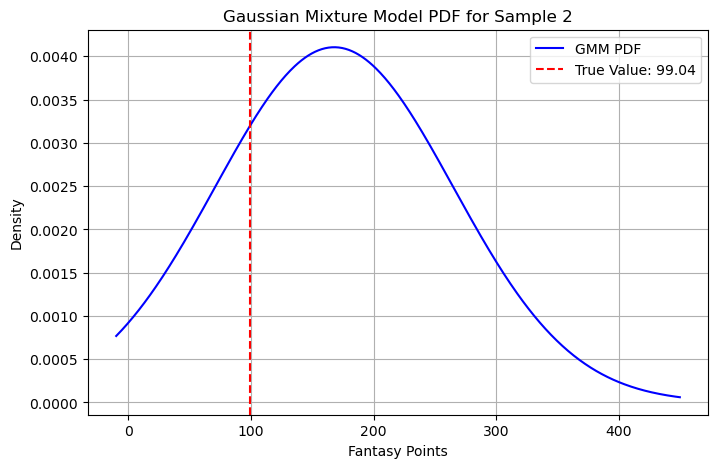

In [15]:
def plot_gaussian_mixture(index, all_means, all_variances, all_weights, all_true_values):
    """
    Plots the Gaussian Mixture Model (GMM) distribution for a given sample index.
    
    Args:
        index (int): Index of the sample to plot.
        all_means (tensor): Shape (sample_size, num_of_gaussians), means of the Gaussians.
        all_variances (tensor): Shape (sample_size, num_of_gaussians), variances of the Gaussians.
        all_weights (tensor): Shape (sample_size, num_of_gaussians), weights of the Gaussians.
        all_true_values (tensor): Shape (sample_size,), actual target values.
    """
    means = all_means[index].cpu().numpy()
    variances = all_variances[index].cpu().numpy()
    weights = all_weights[index].cpu().numpy()
    true_value = all_true_values[index].item()

    num_gaussians = len(means)
    x = np.linspace(-10, 450, 500)  # Adjusted range for better visualization
    pdf = np.zeros_like(x)

    # Compute the mixture density
    for i in range(num_gaussians):
        pdf += weights[i] * norm.pdf(x, loc=means[i], scale=np.sqrt(variances[i]))

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x, pdf, label="GMM PDF", color="blue")
    plt.axvline(true_value, color="red", linestyle="dashed", label=f"True Value: {true_value:.2f}")
    plt.xlabel("Fantasy Points")
    plt.ylabel("Density")
    plt.title(f"Gaussian Mixture Model PDF for Sample {index}")
    plt.legend()
    plt.grid(True)
    plt.show()


selected_index = 2
plot_gaussian_mixture(index=selected_index, all_means=all_means, all_variances=all_variances, all_weights=all_weights, all_true_values=all_true_values)

In [16]:
def plot_gaussian_mixture_multiple_seaborn(all_means, all_variances, all_weights, all_true_values, indices):
    """
    Plots the Gaussian Mixture Model (GMM) probability density functions for multiple players using Seaborn.

    Args:
        all_means (torch.Tensor): Tensor of shape (sample_size, num_of_gaussians) containing the means.
        all_variances (torch.Tensor): Tensor of shape (sample_size, num_of_gaussians) containing the variances.
        all_weights (torch.Tensor): Tensor of shape (sample_size, num_of_gaussians) containing the weights.
        all_true_values (torch.Tensor): Tensor of shape (sample_size,) containing the actual target values.
        indices (list of int): Indices of the players to plot.
    """
    sns.set(style="darkgrid", rc={"axes.facecolor": "#2E2E2E", "figure.facecolor": "#1E1E1E"})  # Darker theme

    x = np.linspace(-10, 450, 500)  # Adjusted x-axis range
    colors = sns.color_palette("bright", len(indices))  # Seaborn color palette

    plt.figure(figsize=(10, 6))

    for i, idx in enumerate(indices):
        means = all_means[idx].cpu().numpy()
        variances = all_variances[idx].cpu().numpy()
        weights = all_weights[idx].cpu().numpy()
        true_value = all_true_values[idx].cpu().item()

        pdf = np.zeros_like(x, dtype=np.float64)
        for mean, var, weight in zip(means, variances, weights):
            pdf += weight * norm.pdf(x, mean, np.sqrt(var))

        color = colors[i % len(colors)]
        sns.lineplot(x=x, y=pdf, label=f"Player {idx} (True: {true_value:.2f})", color=color, linewidth=2)

        # Mark the true value with a vertical line
        plt.axvline(true_value, linestyle="dashed", color=color, alpha=0.8, linewidth=2)
        plt.text(true_value, max(pdf) * 0.8, f"{true_value:.1f}", color=color, fontsize=10, ha="right", fontweight="bold")

    plt.xlabel("Fantasy Points", fontsize=12, color="white")
    plt.ylabel("Probability Density", fontsize=12, color="white")
    plt.title("Gaussian Mixture Model PDFs for Selected Players", fontsize=14, color="white")
    plt.xticks(color="white")
    plt.yticks(color="white")
    
    # Adjusting legend
    legend = plt.legend(frameon=True, fontsize=10, facecolor="#2E2E2E", edgecolor="white")
    for text in legend.get_texts():
        text.set_color("white")  # Set legend text color to white

    plt.grid(True, linestyle="dotted", alpha=0.6)
    plt.show()

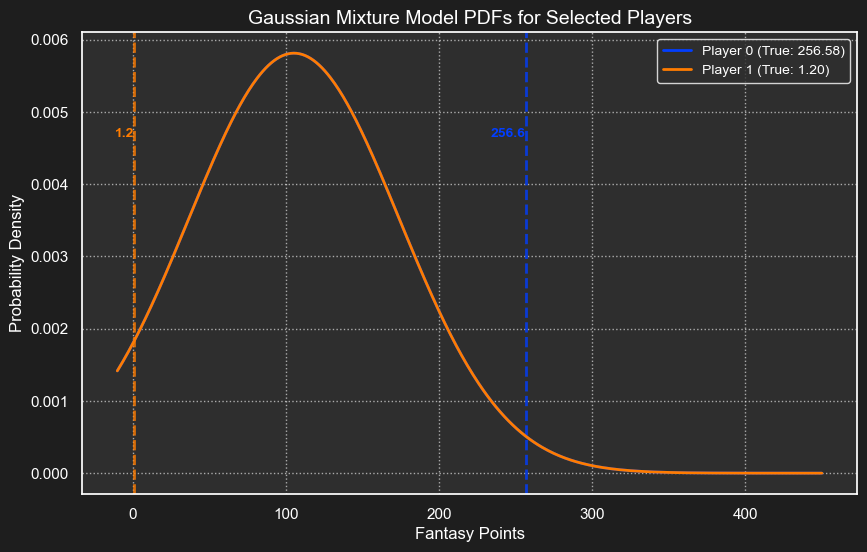

In [33]:
selected_indices = [0,1]
plot_gaussian_mixture_multiple_seaborn(all_means, all_variances, all_weights, all_true_values, indices=selected_indices)

In [86]:
pd.DataFrame(all_weights.cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.525442e-09,0.035414,0.276882,0.000259,3.013925e-08,1.122095e-10,0.472927,6.983348e-10,0.099193,0.019471,4.677024e-08,0.000005,2.481685e-08,0.000224,0.095626
1,2.525419e-09,0.035414,0.276883,0.000259,3.013897e-08,1.122074e-10,0.472926,6.983296e-10,0.099193,0.019471,4.676998e-08,0.000005,2.481681e-08,0.000224,0.095626
2,2.525461e-09,0.035414,0.276882,0.000259,3.013953e-08,1.122105e-10,0.472927,6.983359e-10,0.099193,0.019471,4.677049e-08,0.000005,2.481694e-08,0.000224,0.095626
3,2.525441e-09,0.035414,0.276882,0.000259,3.013952e-08,1.122099e-10,0.472926,6.983358e-10,0.099193,0.019471,4.677040e-08,0.000005,2.481684e-08,0.000224,0.095626
4,2.525443e-09,0.035414,0.276882,0.000259,3.013938e-08,1.122096e-10,0.472927,6.983351e-10,0.099193,0.019471,4.677026e-08,0.000005,2.481686e-08,0.000224,0.095626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,2.525428e-09,0.035414,0.276882,0.000259,3.013908e-08,1.122082e-10,0.472927,6.983308e-10,0.099193,0.019471,4.677007e-08,0.000005,2.481676e-08,0.000224,0.095626
453,2.525420e-09,0.035414,0.276883,0.000259,3.013893e-08,1.122074e-10,0.472926,6.983287e-10,0.099193,0.019471,4.676992e-08,0.000005,2.481682e-08,0.000224,0.095626
454,2.525434e-09,0.035414,0.276882,0.000259,3.013909e-08,1.122083e-10,0.472927,6.983311e-10,0.099193,0.019471,4.677008e-08,0.000005,2.481677e-08,0.000224,0.095626
455,2.525433e-09,0.035414,0.276882,0.000259,3.013925e-08,1.122091e-10,0.472927,6.983347e-10,0.099193,0.019471,4.677006e-08,0.000005,2.481680e-08,0.000224,0.095626


In [ ]:
#Bruh can this work plz